In [2]:
from google.cloud import vision
from pdf2image import convert_from_path
from PIL import Image, ImageDraw, ImageFont
import io
import fitz  # PyMuPDF
import os

In [3]:
client = vision.ImageAnnotatorClient()

I0000 00:00:1731476749.292217 4433908 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported


In [6]:
# look at the metadata for a journal
pdf_dir = "../PDF/Phat_Giao_journals"

In [3]:
def get_image_metadata_from_pdf(pdf_path):
    """
    Extracts metadata of images embedded in each page of a scanned PDF,
    including page dimensions in points and inches, and calculates DPI if missing.
    """
    doc = fitz.open(pdf_path)
    image_metadata = []
    
    for page_num in range(doc.page_count):
        page = doc.load_page(page_num)
        
        # Get page dimensions in points and inches
        page_width_pts, page_height_pts = page.rect.width, page.rect.height
        page_width_in = page_width_pts / 72  # Convert points to inches
        page_height_in = page_height_pts / 72
        
        # Extract the list of images on this page
        images = page.get_images(full=True)  # 'full=True' gets all images on page
        
        for img_index, img in enumerate(images):
            xref = img[0]  # Image reference number
            
            try:
                # Attempt to extract the image and retrieve its metadata
                base_image = doc.extract_image(xref)
                
                # Retrieve metadata about the image
                width_px, height_px = base_image["width"], base_image["height"]
                dpi_x, dpi_y = base_image.get("dpi", (None, None))
                image_metadata.append({
                            "index": img_index,
                            "width": width_px,
                            "height": height_px,
                            "dpi_x": dpi_x,
                            "dpi_y": dpi_y
                        })
            except Exception as e:
                print(f"Error extracting image from {pdf_path}, page {page_num}, at index {img_index}: {e}")
                continue  # Skip to the next image if extraction fails
            
            # Calculate DPI if not provided
            if dpi_x is None or dpi_y is None:
                dpi_x = width_px / page_width_in
                dpi_y = height_px / page_height_in
            
            # Append metadata, including page dimensions and calculated DPI
            image_metadata.append({
                "page": page_num + 1,
                "image_index": img_index + 1,
                "width_px": width_px,
                "height_px": height_px,
                "format": base_image["ext"],
                "dpi_x": dpi_x,
                "dpi_y": dpi_y,
                "page_width_pts": page_width_pts,
                "page_height_pts": page_height_pts,
                "page_width_in": page_width_in,
                "page_height_in": page_height_in,
            })
    
    doc.close()
    return image_metadata

In [ ]:
# Iterate over each PDF file in pdf_dir
for filename in os.listdir(pdf_dir):
    if filename.endswith(".pdf"):
        file_path = os.path.join(pdf_dir, filename)
        
        # Call your function and get metadata
        metadata = get_image_metadata_from_pdf(file_path)
        
        # Display or handle metadata as needed
        print(f"Metadata for {filename}: {metadata}")

Metadata for phat-giao-viet-nam-1956-15.pdf: [{'index': 0, 'width': 1024, 'height': 1536, 'dpi_x': None, 'dpi_y': None}, {'page': 1, 'image_index': 1, 'width_px': 1024, 'height_px': 1536, 'format': 'jpeg', 'dpi_x': 95.51817752805862, 'dpi_y': 95.50646677386379, 'page_width_pts': 771.8740234375, 'page_height_pts': 1157.9530029296875, 'page_width_in': 10.720472547743055, 'page_height_in': 16.08268059624566}, {'index': 0, 'width': 1024, 'height': 1536, 'dpi_x': None, 'dpi_y': None}, {'page': 2, 'image_index': 1, 'width_px': 1024, 'height_px': 1536, 'format': 'jpeg', 'dpi_x': 95.51817752805862, 'dpi_y': 95.50646677386379, 'page_width_pts': 771.8740234375, 'page_height_pts': 1157.9530029296875, 'page_width_in': 10.720472547743055, 'page_height_in': 16.08268059624566}, {'index': 0, 'width': 1024, 'height': 1536, 'dpi_x': None, 'dpi_y': None}, {'page': 3, 'image_index': 1, 'width_px': 1024, 'height_px': 1536, 'format': 'jpeg', 'dpi_x': 95.51817752805862, 'dpi_y': 95.50646677386379, 'page_widt

In [4]:
def build_processed_pdf(directory, filename):
    pil_images = []
    text_pages = []

    file_path = os.path.join(directory, filename)
    print(f"beginning to process: {file_path}")

    # Load PDF and extract image bytes from a given page
    doc = fitz.open(file_path)

    for page_num in range(doc.page_count):
        print(f"processing page: {page_num}...")
        
        page = doc.load_page(page_num)  # Load the first page
        images = page.get_images(full=True)
        xref = images[0][0]  # Get the first image reference
        base_image = doc.extract_image(xref)
        image_bytes = base_image["image"]  # Get the raw JPEG byte content

        # Convert to PIL Image for further processing if needed
        p_image = Image.open(io.BytesIO(image_bytes))
        pil_images.append(p_image)

        # Annotate with vision
        image = vision.Image(content=image_bytes)
        response = client.text_detection(image=image)
        text_annotations = response.text_annotations

        # Build labeled image
        font_size = 15  
        font_path="/System/Library/Fonts/Supplemental/Arial.ttf"
        font = ImageFont.truetype(font_path, font_size)

        draw = ImageDraw.Draw(p_image)
        for i, text_obj in enumerate(text_annotations):
            # Get the bounding box vertices
            vertices = [(vertex.x, vertex.y) for vertex in text_obj.bounding_poly.vertices]

            # Draw a polygon based on the bounding box
            if len(vertices) == 4:
                draw.polygon(vertices, outline="red", width=2)
                if i > 0: # first bounding box is whole text region
                    draw.text(vertices[0], text_obj.description, fill="red", font=font)

        full_page_text = text_annotations[0].description  # always the first text_annotation object
        text_pages.append(full_page_text)

    return text_pages, pil_images

        


In [12]:
import os
import json

def save_annotated_text_and_image_data(root_dir, data_location, text_data, image_data):
    """
    Creates a directory structure to save images, text data, and an HTML gallery for viewing.
    
    Parameters:
        root_dir (str): The root directory to store data.
        data_location (str): Directory location under root_dir for storing files.
        text_data (list of str): List of extracted text for each page.
        image_data (list of tuples): List of tuples, where each tuple contains the image filename (str) 
                                     and the image data (as bytes or PIL image).
                                     
    """
    # Create directory paths
    base_dir = os.path.join(root_dir, data_location)
    os.makedirs(base_dir, exist_ok=True)

    images_dir = os.path.join(base_dir, "images")
    os.makedirs(images_dir, exist_ok=True)
    
    # File paths for JSONL and HTML files
    jsonl_file_path = os.path.join(base_dir, "extracted_text.jsonl")
    html_file_path = os.path.join(base_dir, "index.html")
    
    # Step 1: Save text data to JSONL
    with open(jsonl_file_path, "w", encoding="utf-8") as jsonl_file:
        for i, text in enumerate(text_data):
            entry = {
                "image": f"images/page{i+1}.jpg",  # Image filename
                "text": text
            }
            jsonl_file.write(json.dumps(entry) + "\n")
    
    # Step 2: Save images to the images directory
    for i, img in enumerate(image_data):
        image_path = os.path.join(images_dir, f"page{i+1}.jpg")
        img.save(image_path, format="JPEG")
    
    # Step 3: Generate HTML file for viewing
    with open(html_file_path, "w", encoding="utf-8") as html_file:
        html_file.write("<html><head><title>Annotated Image Gallery</title></head><body>\n")
        html_file.write("<h1>Annotated Image Gallery</h1>\n")
        
        for i, text in enumerate(text_data):
            img_filename = f"images/page{i+1}.jpg"
            html_file.write("<div class='image-entry'>\n")
            html_file.write(f"  <img src='{img_filename}' alt='Page {i+1}' style='width:100%; max-width:600px;'>\n")
            html_file.write(f"  <textarea readonly style='width:100%; height:150px;'>{text}</textarea>\n")
            html_file.write("</div><br>\n")
        
        html_file.write("</body></html>")

    print(f"Data successfully saved in {base_dir}")

# Example usage:
# save_annotated_text_and_image_data(root_dir="my_data", data_location="ocr_project", text_data=["text1", "text2"], image_data=[("img1.jpg", img_bytes), ("img2.jpg", img_bytes)])

In [13]:
def save_xml_text_file(root_dir, data_dir, text_data):
    """
    Generates and saves an XML file with a title and pages, where each page contains text data.
    
    Parameters:
        root_dir (str): The root directory where the XML file will be saved.
        data_dir (str): The directory name for the title tag.
        text_data (list of str): List of extracted text for each page.
    """
    # Define the XML file path
    xml_file_path = os.path.join(root_dir, data_dir, "text_data.xml")
    os.makedirs(os.path.dirname(xml_file_path), exist_ok=True)
    
    # Start writing the XML file
    with open(xml_file_path, "w", encoding="utf-8") as xml_file:
        # Write XML declaration and root element with title
        xml_file.write("<?xml version='1.0' encoding='UTF-8'?>\n")
        xml_file.write(f"<document>\n  <title>{data_dir}</title>\n")
        
        # Add each page with its content
        for i, text in enumerate(text_data):
            # Write each page as <page page="1">...</page>
            xml_file.write(f"  <page page='{i+1}'>\n")
            xml_file.write(f"    {text}\n")
            xml_file.write("  </page>\n")
        
        # Close the root element
        xml_file.write("</document>")

    print(f"XML file successfully saved at {xml_file_path}")

In [ ]:
text_pages, marked_images = build_processed_pdf(pdf_dir, "phat-giao-viet-nam-1956-01.pdf")

In [9]:
data_dir = "./ocr_processed_output"
current_title = "phat-giao-viet-nam-1956-01"

In [11]:
save_annotated_text_and_image_data("./ocr_processed_output", current_title, text_pages, marked_images)

Data successfully saved in ./ocr_processed_output/phat-giao-viet-nam-1956-01


In [14]:
save_xml_text_file(data_dir, current_title, text_pages)

XML file successfully saved at ./ocr_processed_output/phat-giao-viet-nam-1956-01/text_data.xml


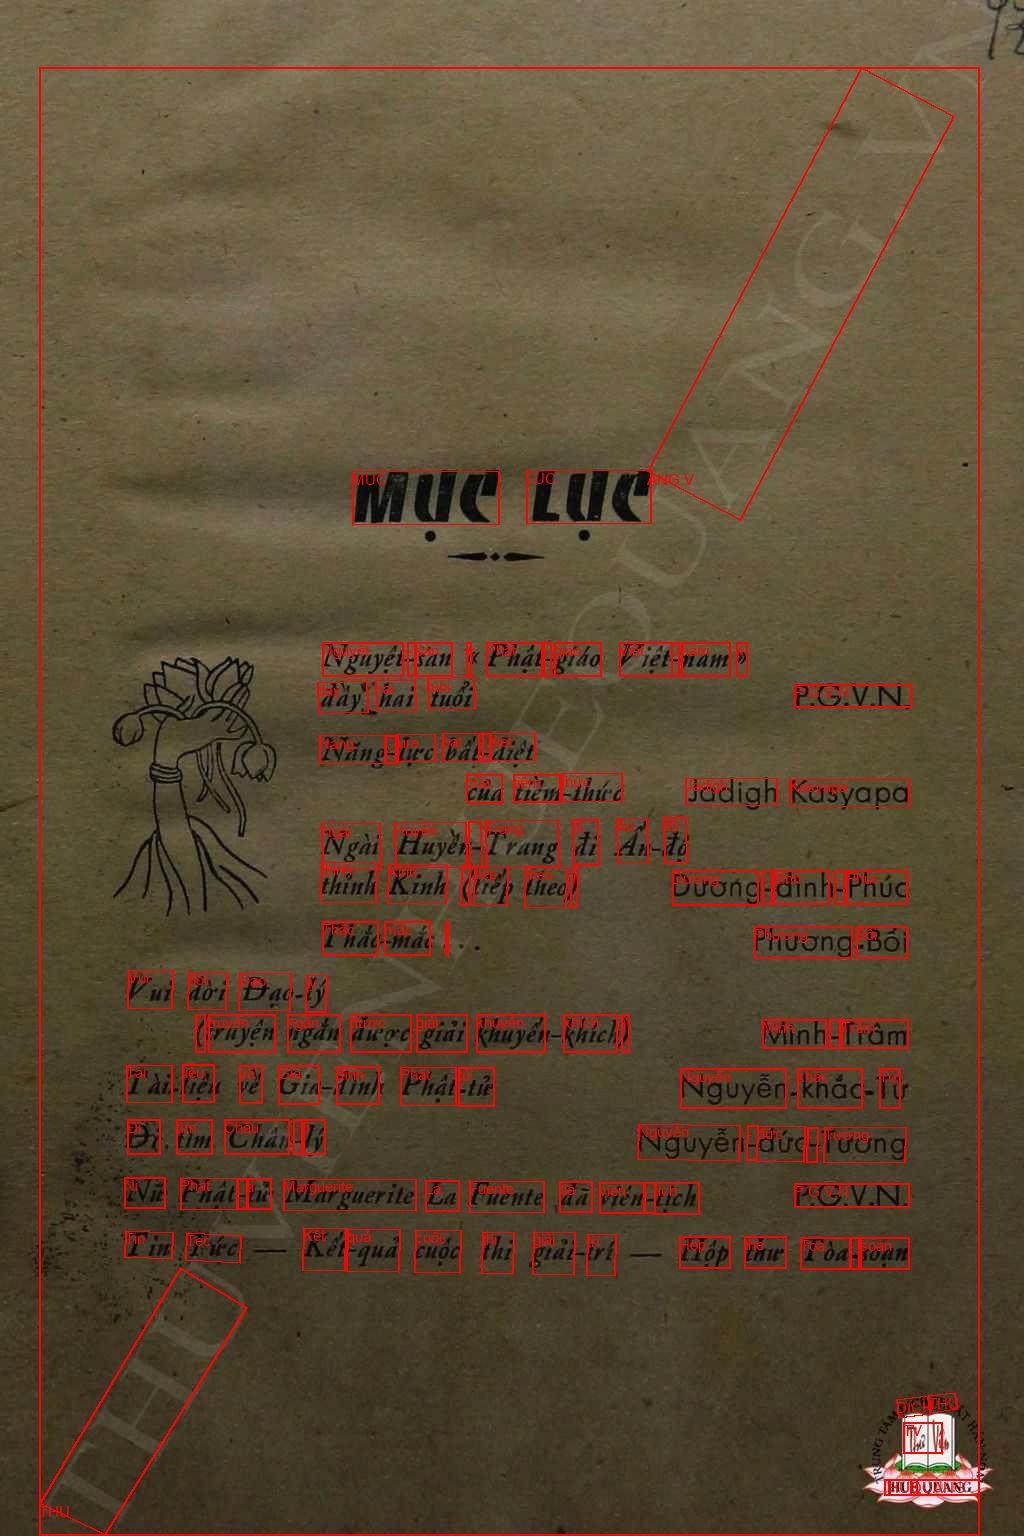

In [49]:
marked_images[1]

In [ ]:
# file_path = os.path.join(pdf_dir, "phat-giao-viet-nam-1956-01.pdf")
# print(file_path)
# # Load PDF and extract image bytes from a given page
# doc = fitz.open(file_path)
# page = doc.load_page(3)  # Load the first page
# images = page.get_images(full=True)
# xref = images[0][0]  # Get the first image reference

# base_image = doc.extract_image(xref)
# image_bytes = base_image["image"]  # Get the raw JPEG byte content

../PDF/Phat_Giao_journals/phat-giao-viet-nam-1956-01.pdf


In [ ]:
# # Convert to PIL Image for further processing if needed
# pil_image = Image.open(io.BytesIO(image_bytes))


In [ ]:
# #annotate with vision
# image = vision.Image(content=image_bytes)
# response = client.text_detection(image=image)

In [ ]:
# text_annotations = response.text_annotations

In [ ]:
# font_size = 15  
# font_path="/System/Library/Fonts/Supplemental/Arial.ttf"
# font = ImageFont.truetype(font_path, font_size)

# draw = ImageDraw.Draw(pil_image)
# for i, text_obj in enumerate(text_annotations):
#     # Get the bounding box vertices
#     vertices = [(vertex.x, vertex.y) for vertex in text_obj.bounding_poly.vertices]

#     # Draw a polygon based on the bounding box
#     if len(vertices) == 4:
#         draw.polygon(vertices, outline="red", width=2)
#         if i > 0: # first bounding box is whole text region
#             draw.text((vertices[0][0], vertices[0][1] + 25), text_obj.description, fill="red", font=font)

